In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/twitter-entity-sentiment-analysis


In [3]:
import os
import pandas as pd

# List files in the dataset directory
dataset_path = path
print("Files in dataset directory:", os.listdir(dataset_path))

Files in dataset directory: ['twitter_validation.csv', 'twitter_training.csv']


In [9]:
train_file = os.path.join(dataset_path, 'twitter_training.csv')
train_df = pd.read_csv(train_file, names=['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Content'], header=None)

# Display the first few rows of the dataset
print(train_df.head())

   Tweet_ID       Entity Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                       Tweet_Content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [10]:
valid_file = os.path.join(dataset_path, 'twitter_validation.csv')
# Load datasets

val_df = pd.read_csv(valid_file, names=['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Content'], header=None)

# Display the first few rows of the dataset
print(val_df.head())

   Tweet_ID     Entity   Sentiment  \
0      3364   Facebook  Irrelevant   
1       352     Amazon     Neutral   
2      8312  Microsoft    Negative   
3      4371      CS-GO    Negative   
4      4433     Google     Neutral   

                                       Tweet_Content  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet hacking,...  
4  Now the President is slapping Americans in the...  


## Introduction
In the age of social media, the likes of Twitter provide the world with a massive repository of public opinions, with millions of opinions on brands, products, organizations; events, etc., appearing every second. The ability to determine the sentiment of the feeling conveyed by these tweets regarding particular entities, which can be either Positive, Negative, or Neutral, is an important exercise for the business; the policymakers; and researchers—with the aim of measuring public perception; tracking brand reputation; or monitoring market trends. The Twitter Entity Sentiment Analysis dataset relieves this challenge by supplying an organized set of tweets along with the corresponding sentiment towards a certain entity making sure that there are cases where the tweet is neutral i.e. irrelevant to the entity. This problem matters because precise sentiment analysis is useful for organizations to make decisions based on data, for example, by improving customer experience, updating marketing strategies or reacting to public concerns in real time. Also, the Twitter data has a very informal and noisy appearance punctuated with slang, emojis, and abbreviations, which adds up a unique set of problems for natural language processing that make the field rather interesting for researchers looking to hand up text analysis techniques. By looking at entity specific sentiments, this job makes a contribution into the larger area of opinion mining, raising questions about how conversational dynamics mold perspectives of entities in a living, digital world.

## Problem Statement
The Twitter Entity Sentiment Analysis dataset gives the challenge of carrying out entity-level sentiment classification for tweets. Given a tweet and a particular entity (brand/product/org etc), the problem is to classify the sentiment conveyed by the tweet of this entity into 3 classes, Positive, Negative, or Neutral. The Tweets that are not relevant to the entity that they do not contain a clear sentiment about the entity, are labeled as Neutral. The data encompasses test and validation sets, each comprising of tweets with attributes such as a unique twitter VAtt ID, target entity, labeled sentiment (positive, negative, neutral or irrelevant) and the actual text of the twittered content. The goal is to build a model, or analytical approach, which can correctly classify the sentiment of a tweet toward the specified entity, dealing with noisy text, with informal language, and making a distinction between neutral and irrelevant sentiments, while taking into account possible class imbalances and the entity-specificity contexts.

## EDA


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
train_df.columns

Index(['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Content', 'Entity_Mentioned'], dtype='object')

In [11]:
# Combine Irrelevant with Neutral as per dataset description
train_df['Sentiment'] = train_df['Sentiment'].replace('Irrelevant', 'Neutral')
val_df['Sentiment'] = val_df['Sentiment'].replace('Irrelevant', 'Neutral')

## Dataset Oerview

In [12]:
#  Dataset Overview
print("\n=== Dataset Overview ===")
print("Training Dataset Info:")
print(train_df.info())
print("\nValidation Dataset Info:")
print(val_df.info())

# Unique values
print("\nUnique Values in Training Dataset:")
print(f"Tweet IDs: {train_df['Tweet_ID'].nunique()}")
print(f"Entities: {train_df['Entity'].nunique()}")
print(f"Sentiments: {train_df['Sentiment'].nunique()}")

# Missing values
print("\nMissing Values in Training Dataset:")
print(train_df.isnull().sum())
print("\nMissing Values in Validation Dataset:")
print(val_df.isnull().sum())

# Duplicates
print("\nDuplicate Tweets in Training Dataset:")
print(train_df['Tweet_Content'].duplicated().sum())


=== Dataset Overview ===
Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet_Content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None

Validation Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       1000 non-null   int64 
 1   Entity         1000 non-null   object
 2   Sentiment      1000 non-null   object
 3   Tweet_Content  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None

Unique Values in Training Dataset:
Tweet IDs: 12447
Entities: 32
Sentiments: 3

Miss

In [14]:
# Original dataset size
original_size = len(train_df)
print(f"Original Dataset Size: {original_size}")

# Step 1: Remove missing values in Tweet_Content
train_df_cleaned = train_df.dropna(subset=['Tweet_Content'])
size_after_missing = len(train_df_cleaned)
missing_loss = original_size - size_after_missing
missing_percent = (missing_loss / original_size) * 100
print(f"Size After Removing Missing Values: {size_after_missing}")
print(f"Data Loss from Missing Values: {missing_loss} rows ({missing_percent:.2f}%)")

# Step 2: Remove duplicates based on Tweet_Content, keeping first occurrence
train_df_cleaned = train_df_cleaned.drop_duplicates(subset=['Tweet_Content'], keep='first')
size_after_duplicates = len(train_df_cleaned)
duplicate_loss = size_after_missing - size_after_duplicates
duplicate_percent = (duplicate_loss / original_size) * 100
total_loss = original_size - size_after_duplicates
total_percent = (total_loss / original_size) * 100
print(f"Size After Removing Duplicates: {size_after_duplicates}")
print(f"Data Loss from Duplicates: {duplicate_loss} rows ({duplicate_percent:.2f}%)")
print(f"Total Data Loss: {total_loss} rows ({total_percent:.2f}%)")

# Verify cleaned dataset distributions
print("\nSentiment Distribution After Cleaning:")
print(train_df_cleaned['Sentiment'].value_counts())
print("\nEntity Distribution (Top 10) After Cleaning:")
print(train_df_cleaned['Entity'].value_counts().head(10))

Original Dataset Size: 74682
Size After Removing Missing Values: 73996
Data Loss from Missing Values: 686 rows (0.92%)
Size After Removing Duplicates: 69491
Data Loss from Duplicates: 4505 rows (6.03%)
Total Data Loss: 5191 rows (6.95%)

Sentiment Distribution After Cleaning:
Sentiment
Neutral     29258
Negative    21166
Positive    19067
Name: count, dtype: int64

Entity Distribution (Top 10) After Cleaning:
Entity
MaddenNFL               2260
CallOfDuty              2259
Verizon                 2258
NBA2K                   2242
Facebook                2226
Microsoft               2224
TomClancysGhostRecon    2220
johnson&johnson         2220
WorldOfCraft            2209
TomClancysRainbowSix    2209
Name: count, dtype: int64



=== Sentiment Distribution ===
Training Sentiment Counts:
Sentiment
Neutral     29258
Negative    21166
Positive    19067
Name: count, dtype: int64

Validation Sentiment Counts:
Sentiment
Neutral     457
Positive    277
Negative    266
Name: count, dtype: int64


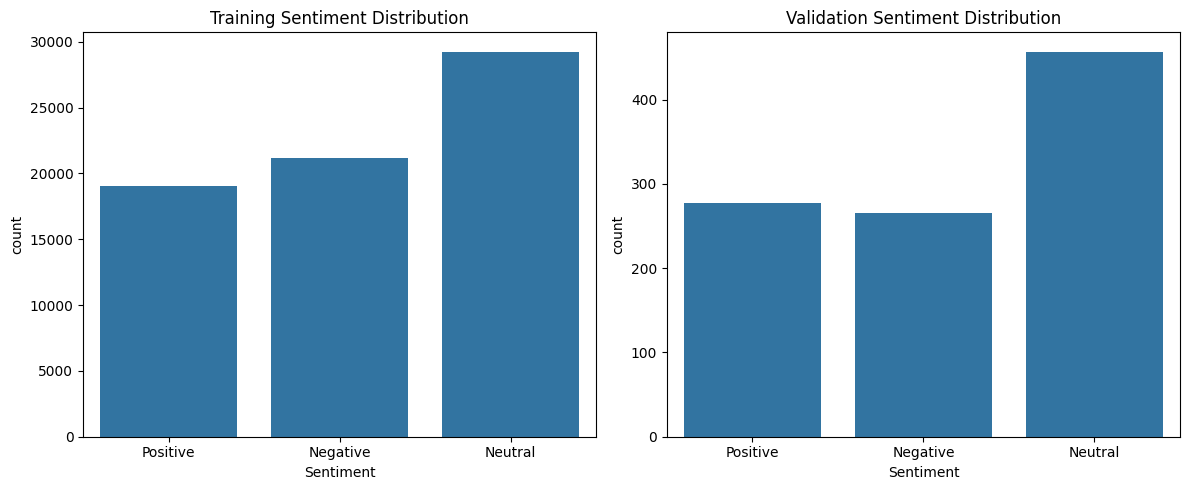

In [16]:
# Sentiment Distribution
print("\n=== Sentiment Distribution ===")
print("Training Sentiment Counts:")
print(train_df_cleaned['Sentiment'].value_counts())
print("\nValidation Sentiment Counts:")
print(val_df['Sentiment'].value_counts())

# Visualization: Sentiment Distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Sentiment', data=train_df_cleaned, order=['Positive', 'Negative', 'Neutral'])
plt.title('Training Sentiment Distribution')
plt.subplot(1, 2, 2)
sns.countplot(x='Sentiment', data=val_df, order=['Positive', 'Negative', 'Neutral'])
plt.title('Validation Sentiment Distribution')
plt.tight_layout()
plt.show()

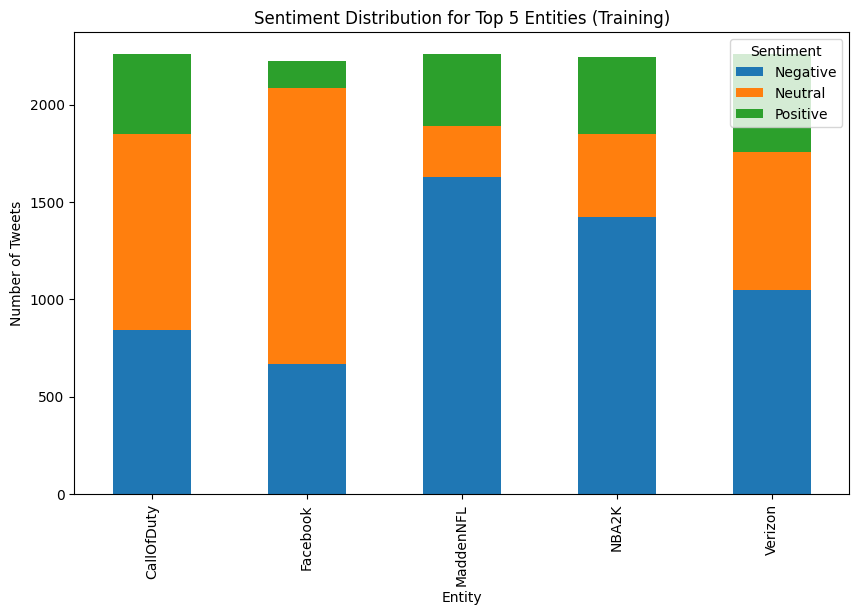


=== Entity Analysis ===
Top 10 Entities in Training Dataset:
Entity
MaddenNFL               2260
CallOfDuty              2259
Verizon                 2258
NBA2K                   2242
Facebook                2226
Microsoft               2224
TomClancysGhostRecon    2220
johnson&johnson         2220
WorldOfCraft            2209
TomClancysRainbowSix    2209
Name: count, dtype: int64

Top 10 Entities in Validation Dataset:
Entity
RedDeadRedemption(RDR)               40
johnson&johnson                      39
PlayerUnknownsBattlegrounds(PUBG)    38
FIFA                                 38
LeagueOfLegends                      37
ApexLegends                          36
Nvidia                               35
TomClancysRainbowSix                 35
GrandTheftAuto(GTA)                  35
Amazon                               34
Name: count, dtype: int64


In [18]:
# Sentiment by Top Entities (Training)
top_entities = train_df_cleaned['Entity'].value_counts().head(5).index
entity_sentiment = train_df_cleaned[train_df_cleaned['Entity'].isin(top_entities)].groupby(['Entity', 'Sentiment']).size().unstack()
entity_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution for Top 5 Entities (Training)')
plt.ylabel('Number of Tweets')
plt.show()



=== Entity Analysis ===
Top 10 Entities in Training Dataset:
Entity
MaddenNFL               2260
CallOfDuty              2259
Verizon                 2258
NBA2K                   2242
Facebook                2226
Microsoft               2224
TomClancysGhostRecon    2220
johnson&johnson         2220
WorldOfCraft            2209
TomClancysRainbowSix    2209
Name: count, dtype: int64

Top 10 Entities in Validation Dataset:
Entity
RedDeadRedemption(RDR)               40
johnson&johnson                      39
PlayerUnknownsBattlegrounds(PUBG)    38
FIFA                                 38
LeagueOfLegends                      37
ApexLegends                          36
Nvidia                               35
TomClancysRainbowSix                 35
GrandTheftAuto(GTA)                  35
Amazon                               34
Name: count, dtype: int64


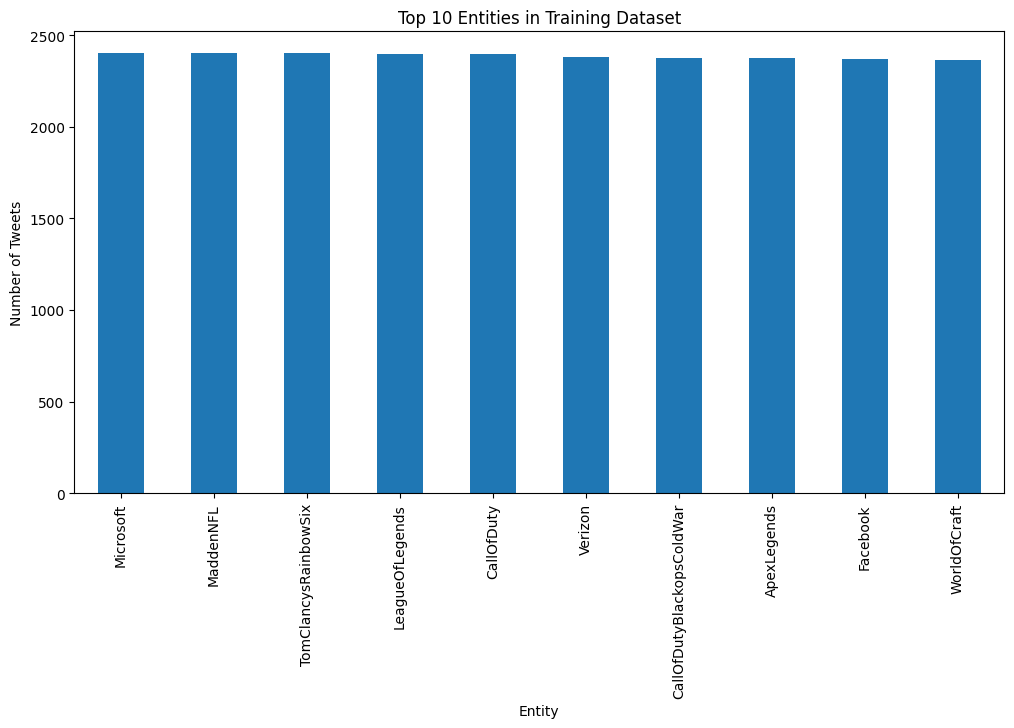

In [19]:

# Entity Analysis
print("\n=== Entity Analysis ===")
print("Top 10 Entities in Training Dataset:")
print(train_df_cleaned['Entity'].value_counts().head(10))
print("\nTop 10 Entities in Validation Dataset:")
print(val_df['Entity'].value_counts().head(10))
# Visualization: Entity Frequency
plt.figure(figsize=(12, 6))
train_df['Entity'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Entities in Training Dataset')
plt.ylabel('Number of Tweets')
plt.show()


=== Tweet Length Statistics ===
Training Tweet Length:
count    69491.000000
mean       112.906247
std         78.248855
min          1.000000
25%         52.000000
50%         95.000000
75%        157.000000
max        957.000000
Name: Tweet_Length, dtype: float64

Validation Tweet Length:
count    1000.000000
mean      131.849000
std        81.925429
min         3.000000
25%        67.750000
50%       114.000000
75%       190.250000
max       340.000000
Name: Tweet_Length, dtype: float64


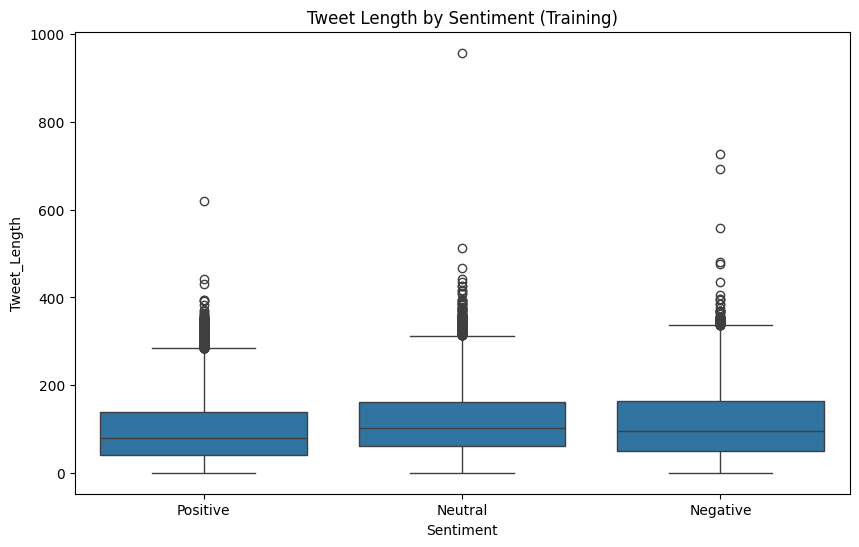

In [20]:
#Tweet Content Analysis
# Tweet Length
train_df_cleaned['Tweet_Length'] = train_df_cleaned['Tweet_Content'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
val_df['Tweet_Length'] = val_df['Tweet_Content'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

print("\n=== Tweet Length Statistics ===")
print("Training Tweet Length:")
print(train_df_cleaned['Tweet_Length'].describe())
print("\nValidation Tweet Length:")
print(val_df['Tweet_Length'].describe())

# Visualization: Tweet Length by Sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment', y='Tweet_Length', data=train_df_cleaned)
plt.title('Tweet Length by Sentiment (Training)')
plt.show()


=== Top 20 Words (Training) ===
Overall: [('the', 43024), ('i', 35275), ('to', 28042), ('and', 26195), ('a', 23753), ('of', 18796), ('it', 17457), ('is', 17318), ('in', 15522), ('for', 15454), ('this', 14394), ('you', 12800), ('on', 11945), ('my', 11620), ('t', 11495), ('s', 11034), ('that', 10650), ('com', 9563), ('with', 8772), ('game', 8150)]
Positive: [('the', 11445), ('i', 11273), ('to', 7386), ('and', 6778), ('a', 5788), ('it', 5036), ('of', 4915), ('is', 4324), ('for', 4302), ('this', 4128), ('in', 3769), ('my', 3220), ('s', 3092), ('on', 2765), ('you', 2667), ('so', 2664), ('that', 2612), ('t', 2292), ('game', 2261), ('with', 2171)]
Negative: [('the', 13656), ('i', 11871), ('to', 8859), ('and', 8537), ('a', 7392), ('is', 6686), ('it', 6022), ('of', 5606), ('this', 4857), ('in', 4788), ('you', 4674), ('t', 4348), ('for', 4234), ('my', 4135), ('that', 3974), ('on', 3784), ('game', 3777), ('s', 3274), ('with', 2802), ('not', 2618)]
Neutral: [('the', 17923), ('i', 12131), ('to', 1

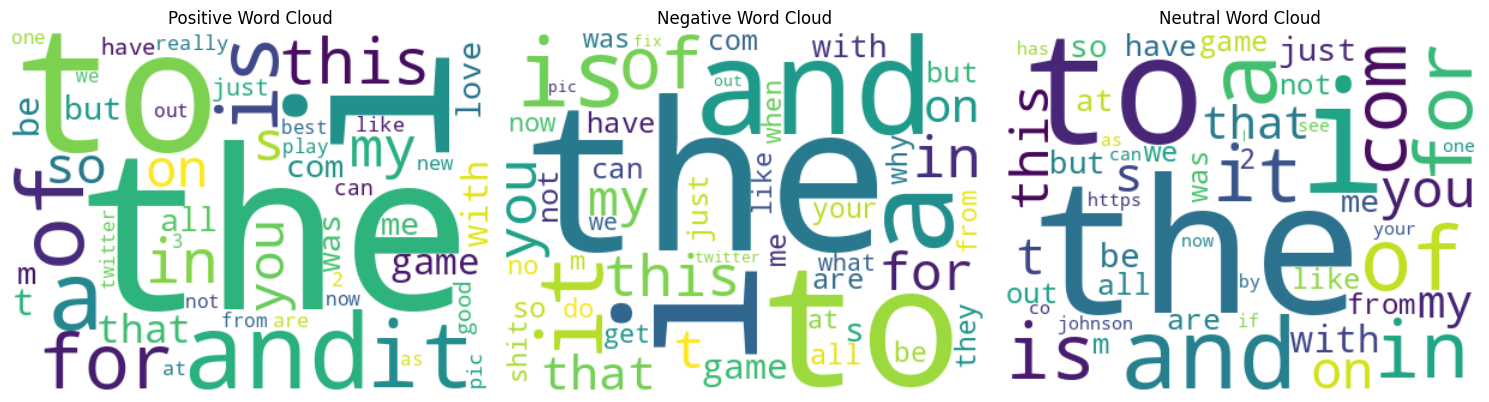

In [25]:
# Word Frequency
def get_top_words(text_series, sentiment=None, n=20):
    if sentiment:
        texts = text_series[train_df['Sentiment'] == sentiment].dropna()
    else:
        texts = text_series.dropna()
    words = ' '.join(texts).lower()
    words = re.findall(r'\b\w+\b', words)
    return Counter(words).most_common(n)

print("\n=== Top 20 Words (Training) ===")
print("Overall:", get_top_words(train_df_cleaned['Tweet_Content']))
print("Positive:", get_top_words(train_df_cleaned['Tweet_Content'], 'Positive'))
print("Negative:", get_top_words(train_df_cleaned['Tweet_Content'], 'Negative'))
print("Neutral:", get_top_words(train_df_cleaned['Tweet_Content'], 'Neutral'))

# Word Clouds
plt.figure(figsize=(15, 5))
for i, sentiment in enumerate(['Positive', 'Negative', 'Neutral'], 1):
    plt.subplot(1, 3, i)
    words = dict(get_top_words(train_df_cleaned['Tweet_Content'], sentiment, 50))
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{sentiment} Word Cloud')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
# Entity Mention in Tweet Content
train_df_cleaned['Entity_Mentioned'] = train_df_cleaned.apply(
    lambda x: str(x['Entity']).lower() in str(x['Tweet_Content']).lower() if pd.notnull(x['Tweet_Content']) else False, axis=1
)
print("\n=== Entity Mention in Tweet Content (Training) ===")
print(train_df_cleaned.groupby('Sentiment')['Entity_Mentioned'].mean())


=== Entity Mention in Tweet Content (Training) ===
Sentiment
Negative    0.400643
Neutral     0.282589
Positive    0.246342
Name: Entity_Mentioned, dtype: float64


In [27]:
# Temporal and Contextual Insights (Using Tweet ID as Proxy)
print("\n=== Tweet ID Range (Proxy for Temporal Analysis) ===")
print("Training Tweet ID Range:", train_df_cleaned['Tweet_ID'].min(), "to", train_df_cleaned['Tweet_ID'].max())
print("Validation Tweet ID Range:", val_df['Tweet_ID'].min(), "to", val_df['Tweet_ID'].max())


=== Tweet ID Range (Proxy for Temporal Analysis) ===
Training Tweet ID Range: 1 to 13200
Validation Tweet ID Range: 6 to 13197


In [30]:
#  Challenges and Anomalies
# Short Tweets
short_tweets = train_df_cleaned[train_df_cleaned['Tweet_Length'] < 10]
print("\n=== Short Tweets (<10 chars) in Training ===")
print(f"Number of short tweets: {len(short_tweets)}")
print(short_tweets[['Tweet_Content', 'Sentiment']].head())

# Ambiguous Neutral Tweets
neutral_tweets = train_df_cleaned[train_df_cleaned['Sentiment'] == 'Neutral']['Tweet_Content'].dropna()
print("\n=== Sample Neutral Tweets ===")
print(neutral_tweets.sample(5, random_state=42).to_list())


=== Short Tweets (<10 chars) in Training ===
Number of short tweets: 1030
   Tweet_Content Sentiment
11           was  Positive
53           all   Neutral
60       . . [     Neutral
62          .. [   Neutral
63         .. 45   Neutral

=== Sample Neutral Tweets ===
['A guy literally sent me a friend request on Facebook and his bio read “.... racist and hitler is cool” ????? . . I reported and blocked him . ', 'A penalty for Battlefield I player POLYSTATION7 has occurred … DETAILS: bf4db.com/player/ban/100…', 'Sage Apothecary Gold Multi Lime Sanitizer 1 Pro. Learn More. ift.tt/33wO1jT', 'A bit scary but a tiny dink _ 3 1 @FearRTs @Mighty_Rts @GFXCoach @FlyRTs 8 And]', "At 12, I realized that I couldn't trust my friends when I had to disable MFker for not returning GTA: San."]


# Using Deep Learning Pipelines for Sentiment Analysis

## Text Cleaning

In [31]:
# Text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|@\S+|#\S+', '', text)  # Remove URLs, mentions, hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply text cleaning to Tweet_Content
train_df_cleaned['Tweet_Content_Cleaned'] = train_df_cleaned['Tweet_Content'].apply(clean_text)
val_df['Tweet_Content_Cleaned'] = val_df['Tweet_Content'].apply(clean_text)

## Class Balancing

In [49]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder on the 'Sentiment' column and transform it to numerical labels
train_df_cleaned['Sentiment_Label'] = label_encoder.fit_transform(train_df_cleaned['Sentiment'])
val_df['Sentiment_Label'] = label_encoder.transform(val_df['Sentiment'])
# Check sentiment distribution
print("Training Sentiment Distribution:")
print(train_df_cleaned['Sentiment'].value_counts())
print("\nValidation Sentiment Distribution:")
print(val_df['Sentiment'].value_counts())

# Compute class weights based on training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df_cleaned['Sentiment_Label']),
    y=train_df_cleaned['Sentiment_Label']
)

# Create a dictionary mapping class indices to weights
class_weights_dict = dict(zip(np.unique(train_df_cleaned['Sentiment_Label']), class_weights))
print("\nClass Weights:", class_weights_dict)

# Map weights to sentiment labels for readability
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
class_weights_labeled = {label_mapping[k]: v for k, v in class_weights_dict.items()}
print("Class Weights (Labeled):", class_weights_labeled)

Training Sentiment Distribution:
Sentiment
Neutral     29258
Negative    21166
Positive    19067
Name: count, dtype: int64

Validation Sentiment Distribution:
Sentiment
Neutral     457
Positive    277
Negative    266
Name: count, dtype: int64

Class Weights: {np.int64(0): np.float64(1.0943809253834766), np.int64(1): np.float64(0.7917036935766856), np.int64(2): np.float64(1.2148563836296569)}
Class Weights (Labeled): {'Negative': np.float64(1.0943809253834766), 'Neutral': np.float64(0.7917036935766856), 'Positive': np.float64(1.2148563836296569)}


In [50]:
from transformers import BertTokenizer
import re
import torch
from torch.utils.data import Dataset

# Text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|@\S+|#\S+', '', text)  # Remove URLs, mentions, hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply text cleaning
train_df_cleaned['Tweet_Content_Cleaned'] = train_df_cleaned['Tweet_Content'].apply(clean_text)
val_df['Tweet_Content_Cleaned'] = val_df['Tweet_Content'].apply(clean_text)

# Custom dataset class for BERT
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = TweetDataset(
    train_df_cleaned['Tweet_Content_Cleaned'].values,
    train_df_cleaned['Sentiment_Label'].values,
    tokenizer
)
val_dataset = TweetDataset(
    val_df['Tweet_Content_Cleaned'].values,
    val_df['Sentiment_Label'].values,
    tokenizer
)

# Check class balance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df_cleaned['Sentiment_Label']),
    y=train_df_cleaned['Sentiment_Label']
)
print("Class Weights:", dict(zip(label_encoder.classes_, class_weights)))

Class Weights: {'Negative': np.float64(1.0943809253834766), 'Neutral': np.float64(0.7917036935766856), 'Positive': np.float64(1.2148563836296569)}


## Training BERT Model

In [54]:
import torch
from transformers import BertForSequenceClassification

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3  # Positive, Negative, Neutral
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Custom training loop to include class weights
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': accuracy, 'f1': f1}

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # Replace 'evaluation_strategy' with 'eval_strategy'
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=100,
    # Add report_to to suppress warnings
    report_to="none"
)


# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.373600,0.126092,0.963000,0.963064
2,0.183400,0.102411,0.980000,0.980001


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.373600,0.126092,0.963000,0.963064
2,0.183400,0.102411,0.980000,0.980001
3,0.061200,0.110655,0.982000,0.981995


Evaluation Results: {'eval_loss': 0.10241120308637619, 'eval_accuracy': 0.98, 'eval_f1': 0.9800013064543186, 'eval_runtime': 7.1711, 'eval_samples_per_second': 139.448, 'eval_steps_per_second': 8.785, 'epoch': 3.0}


In [58]:


# Extract metrics from trainer logs
log_history = trainer.state.log_history

# Initialize lists to store metrics
train_loss = []
val_loss = []
val_accuracy = []
val_f1 = []
steps = []

# Parse log history
for log in log_history:
    if 'loss' in log and 'step' in log:  # Training loss
        train_loss.append(log['loss'])
        steps.append(log['step'])
    if 'eval_loss' in log:  # Validation metrics
        val_loss.append(log['eval_loss'])
        val_accuracy.append(log['eval_accuracy'])
        val_f1.append(log['eval_f1'])


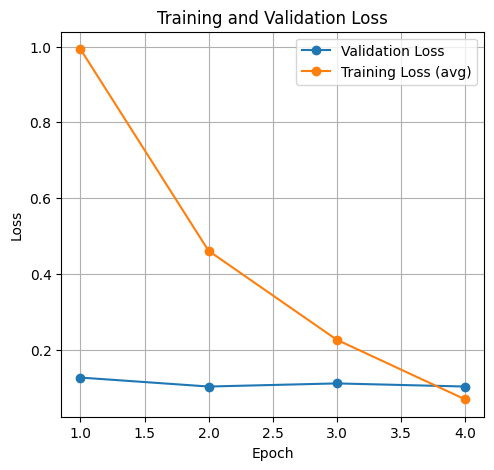

In [59]:
# Since eval is per epoch, create epoch-based x-axis (3 epochs)
epochs = range(1, len(val_loss) + 1)

#  Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.plot(epochs, [train_loss[int(i * len(train_loss)/len(val_loss))] for i in range(len(val_loss))], label='Training Loss (avg)', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

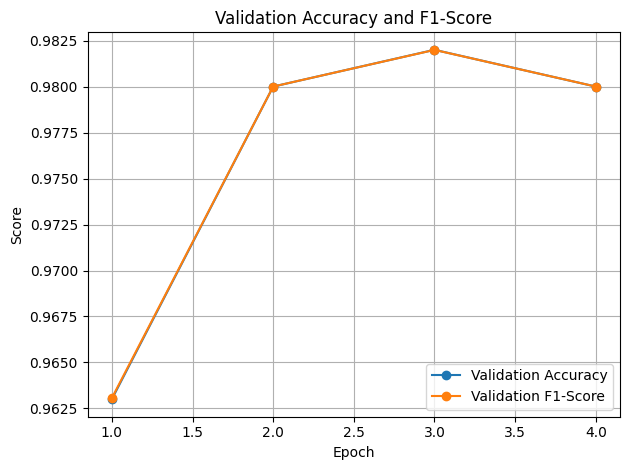

In [61]:
# Validation Accuracy and F1-Score
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.plot(epochs, val_f1, label='Validation F1-Score', marker='o')
plt.title('Validation Accuracy and F1-Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [57]:
# Save model and tokenizer
model.save_pretrained('./bert_sentiment_model')
tokenizer.save_pretrained('./bert_sentiment_model')

# Load model for prediction
loaded_model = BertForSequenceClassification.from_pretrained('./bert_sentiment_model')
loaded_tokenizer = BertTokenizer.from_pretrained('./bert_sentiment_model')

# Predict on new tweet
new_tweet = "I love playing Borderlands, it's so fun!"
cleaned_tweet = clean_text(new_tweet)
encoding = loaded_tokenizer(cleaned_tweet, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
encoding = {k: v.to(device) for k, v in encoding.items()}
loaded_model.to(device)
with torch.no_grad():
    outputs = loaded_model(**encoding)
    pred_label = outputs.logits.argmax(-1).item()
print(f"Predicted Sentiment: {label_encoder.inverse_transform([pred_label])[0]}")

Predicted Sentiment: Positive


## LSTM Model

Applying Oversampling for Class balancing because the LSTM model is more sensitive to Class imbalance

In [66]:
# Separate classes
neutral_df = train_df_cleaned[train_df_cleaned['Sentiment'] == 'Neutral']
negative_df = train_df_cleaned[train_df_cleaned['Sentiment'] == 'Negative']
positive_df = train_df_cleaned[train_df_cleaned['Sentiment'] == 'Positive']

# Oversample minority classes to match Neutral
negative_oversampled = resample(
    negative_df,
    replace=True,
    n_samples=len(neutral_df),  # Match Neutral's count (~29,258)
    random_state=42
)
positive_oversampled = resample(
    positive_df,
    replace=True,
    n_samples=len(neutral_df),  # Match Neutral's count (~29,258)
    random_state=42
)


In [67]:
# Combine balanced dataset
train_df_balanced = pd.concat([neutral_df, negative_oversampled, positive_oversampled])

# Verify balanced distribution
print("Balanced Training Sentiment Distribution:")
print(train_df_balanced['Sentiment'].value_counts())
print(f"Balanced Dataset Size: {len(train_df_balanced)}")

Balanced Training Sentiment Distribution:
Sentiment
Neutral     29258
Negative    29258
Positive    29258
Name: count, dtype: int64
Balanced Dataset Size: 87774


### Text Preprocessing

In [68]:
#Preprocess text for LSTM
max_words = 5000
max_len = 100
tokenizer_lstm = Tokenizer(num_words=max_words)
tokenizer_lstm.fit_on_texts(train_df_balanced['Tweet_Content_Cleaned'])
X_train_seq = tokenizer_lstm.texts_to_sequences(train_df_balanced['Tweet_Content_Cleaned'])
X_val_seq = tokenizer_lstm.texts_to_sequences(val_df['Tweet_Content_Cleaned'])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

# Prepare labels
y_train = train_df_balanced['Sentiment_Label']
y_val = val_df['Sentiment_Label']

In [69]:
lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Train LSTM model
history = lstm_model.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    verbose=1
)

Epoch 1/5
2743/2743 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.6286 - loss: 0.8062 - val_accuracy: 0.8690 - val_loss: 0.3876
Epoch 2/5
2743/2743 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.8229 - loss: 0.4489 - val_accuracy: 0.9180 - val_loss: 0.2783
Epoch 3/5
2743/2743 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8789 - loss: 0.3167 - val_accuracy: 0.9300 - val_loss: 0.2248
Epoch 4/5
2743/2743 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9091 - loss: 0.2419 - val_accuracy: 0.9420 - val_loss: 0.2268
Epoch 5/5
2743/2743 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9289 - loss: 0.1942 - val_accuracy: 0.9420 - val_loss: 0.2202


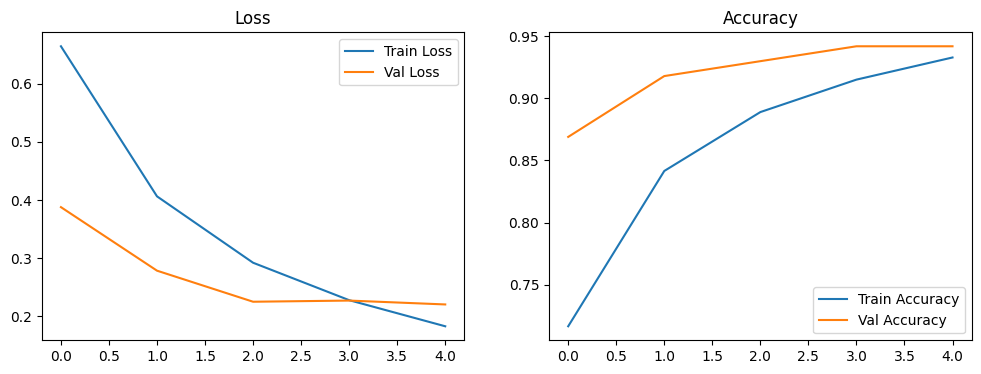

In [71]:
# Step 5: Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94       266
     Neutral       0.95      0.94      0.95       457
    Positive       0.94      0.94      0.94       277

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



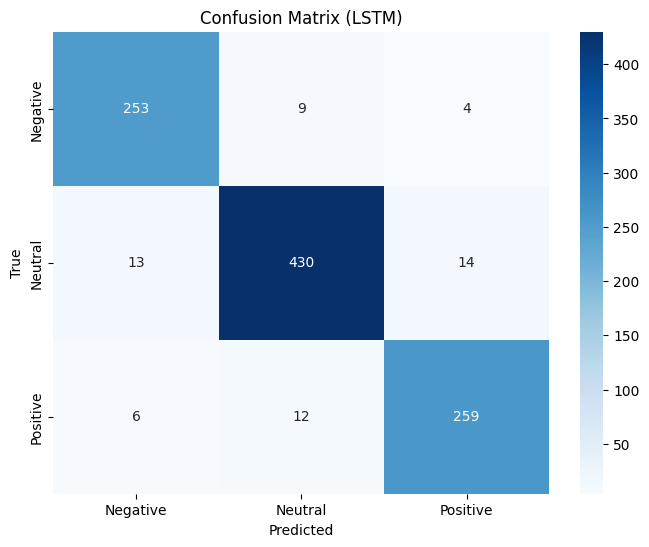

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = lstm_model.predict(X_val_pad).argmax(axis=1)
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (LSTM)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [73]:
 #Predict on a new tweet
def predict_new_tweet(tweet, model, tokenizer, max_len=100):
    # Clean text (same as training preprocessing)
    cleaned_tweet = tweet.lower()
    cleaned_tweet = re.sub(r'http\S+|www\S+|@\S+|#\S+', '', cleaned_tweet)  # Remove URLs, mentions, hashtags
    cleaned_tweet = re.sub(r'[^\w\s]', '', cleaned_tweet)  # Remove punctuation

    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([cleaned_tweet])
    padded = pad_sequences(seq, maxlen=max_len)

    # Predict
    pred = model.predict(padded).argmax(axis=1)
    return label_encoder.inverse_transform(pred)[0]

# Example new tweet
new_tweet = "I love playing Borderlands, it's so fun!"
predicted_sentiment = predict_new_tweet(new_tweet, lstm_model, tokenizer_lstm)
print(f"\nNew Tweet: {new_tweet}")
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

New Tweet: I love playing Borderlands, it's so fun!
Predicted Sentiment: Positive
